In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.circuit.library import ZZFeatureMap
from qiskit.quantum_info import Statevector

In [2]:
ccf_df = pd.read_csv('ccfraud/creditcard.csv')
ccf_df.shape

(284807, 31)

In [3]:
diabetes_df = pd.read_csv('diabetes/diabetes.csv')
diabetes_df.shape

(768, 9)

In [4]:
kdd_df = pd.read_csv('KDD Cup 1999/kddcup.data.csv')
kdd_df.shape

(4898431, 42)

### Credit Card Fraud kdd_dfset analysis

/tmp/ipykernel_10722/2086142342.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=ccf_df, palette='coolwarm')


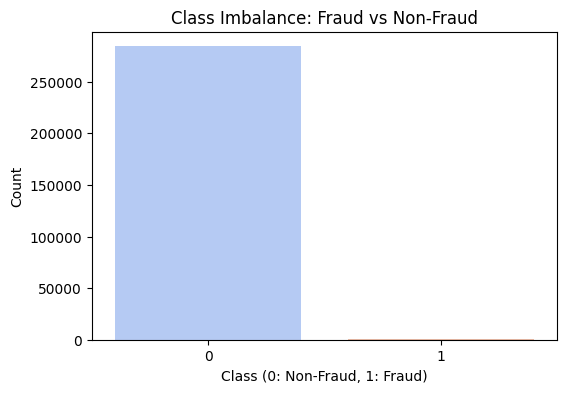

Non-Fraud Count: 284315
Fraud Count: 492


In [30]:
# 1. Class Imbalance Check

plt.figure(figsize=(6, 4))
sns.countplot(hue='Class', kdd_df=ccf_df, palette='coolwarm', legend=False)
plt.title('Class Imbalance: Fraud vs Non-Fraud')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()

print(f"Non-Fraud Count: {ccf_df.loc[ccf_df['Class'] == 0, 'Class'].count()}")
print(f"Fraud Count: {ccf_df.loc[ccf_df['Class'] == 1, 'Class'].count()}")

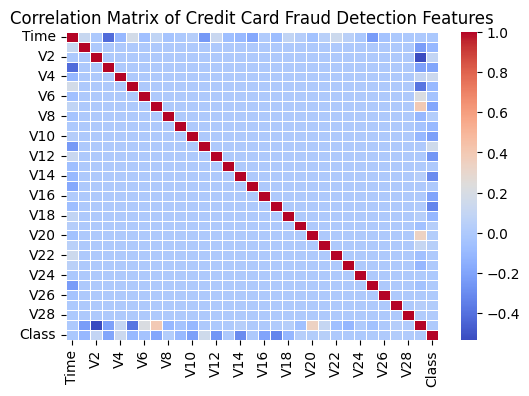

In [45]:
# 2. Correlation Matrix (Heatmap)

plt.figure(figsize=(6, 4))
corr_matrix = ccf_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Credit Card Fraud Detection Features')
plt.show()

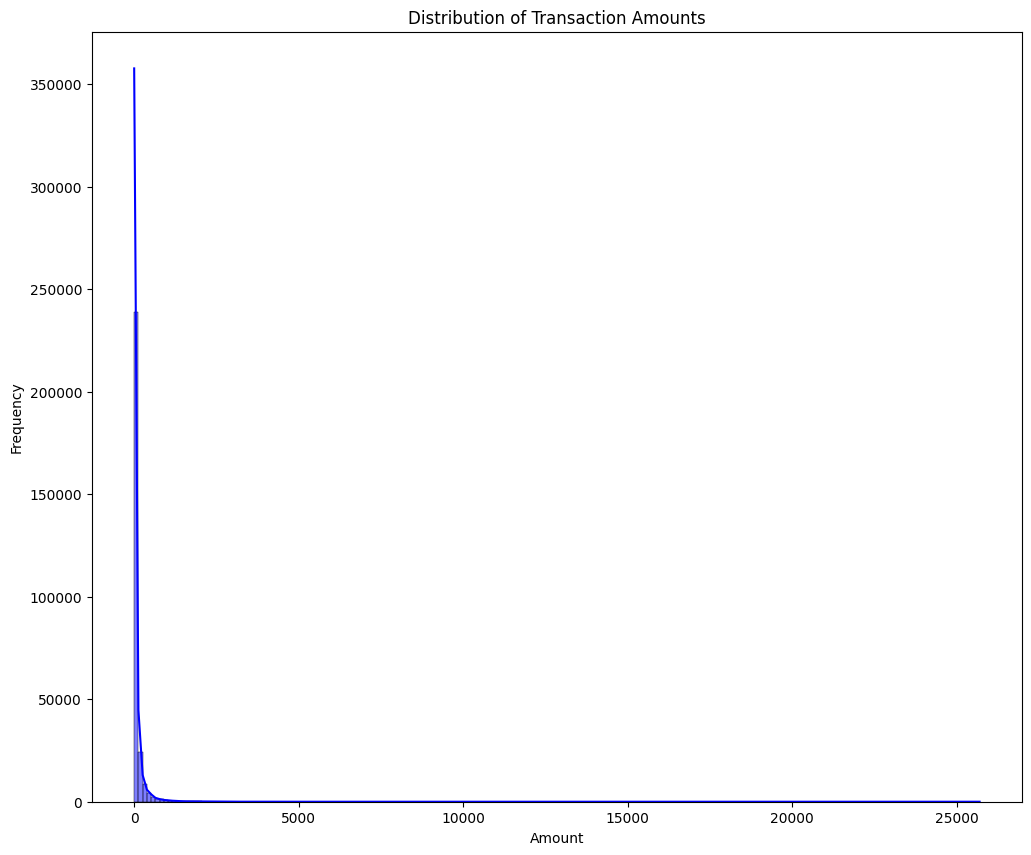

In [42]:
# 3. Distribution of `Amount` Feature

plt.figure(figsize=(12, 10))
sns.histplot(ccf_df['Amount'], bins=200, color='blue', kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

/media/manoj/Personal/Documents (E)/Web Development/Resume Projects/Implement/qml-major-project/qml-anomaly-detection/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


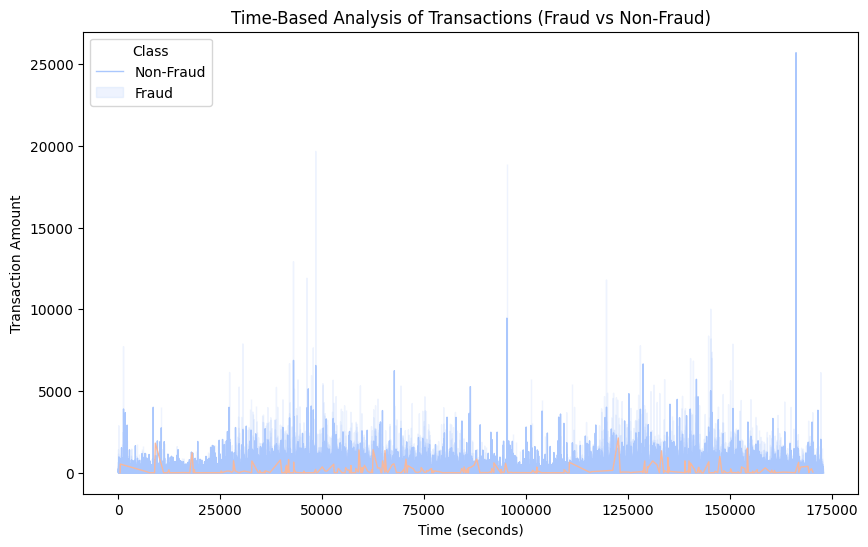

In [43]:
# 4. Time-Based Analysis

plt.figure(figsize=(10, 6))
sns.lineplot(x='Time', y='Amount', hue='Class', data=ccf_df, palette='coolwarm', linewidth=1)
plt.title('Time-Based Analysis of Transactions (Fraud vs Non-Fraud)')
plt.xlabel('Time (seconds)')
plt.ylabel('Transaction Amount')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.show()

/tmp/ipykernel_10722/3408132874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Amount', data=ccf_df, palette='coolwarm')


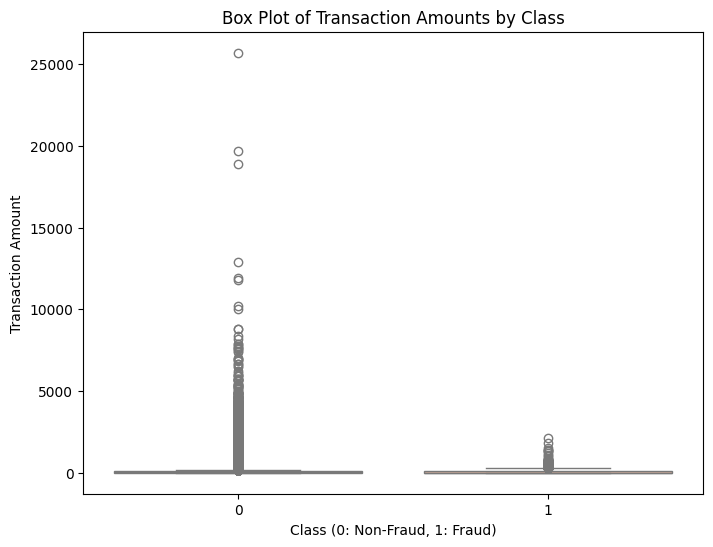

In [44]:
# 5. Box Plot for Outlier Detection
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=ccf_df, palette='coolwarm')
plt.title('Box Plot of Transaction Amounts by Class')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Transaction Amount')
plt.show()

In [16]:
# Step 1: kdd_df Preprocessing for Quantum Embedding
# Standardizing the 'Amount' and 'Time' features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ccf_df[['Amount', 'Time']] = scaler.fit_transform(ccf_df[['Amount', 'Time']])

# Selecting a subset of features for quantum embedding
selected_features = ['V1', 'V2', 'V3', 'Amount', 'Time']
X = ccf_df[selected_features].values[:100]  # Limit to 100 samples for visualization

# Step 2: Quantum Feature Map to Embed kdd_df into Quantum State
feature_map = ZZFeatureMap(feature_dimension=len(selected_features), reps=2, entanglement='linear')

# Function to create quantum circuits for each kdd_df point
quantum_circuits = []
for kdd_dfpoint in X:
    circuit = feature_map.assign_parameters(kdd_dfpoint)
    quantum_circuits.append(circuit)

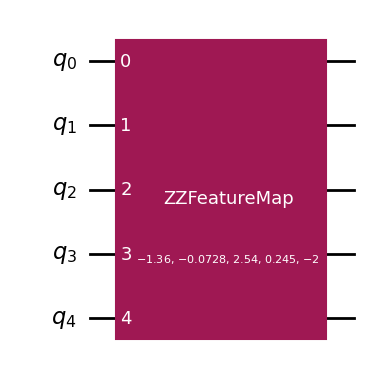

In [18]:
# Visualize one of the quantum circuits as an example
quantum_circuits[0].draw(output='mpl')

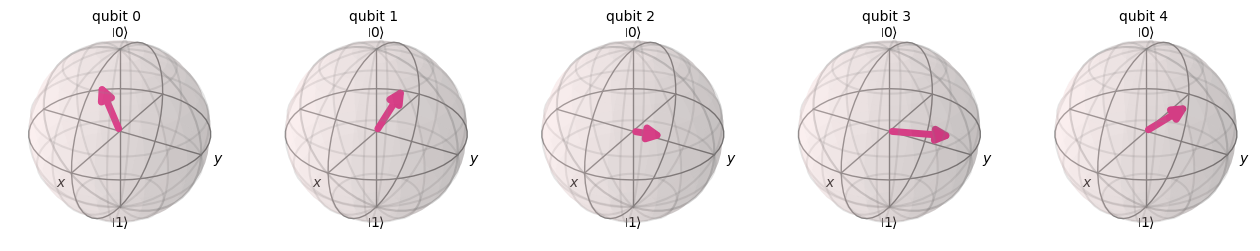

In [19]:
# Step 3: Quantum State Visualization using Bloch Sphere
backend = Aer.get_backend('statevector_simulator')

# Getting quantum state for the first kdd_df point
new_circuit = transpile(quantum_circuits[0], backend)
job = backend.run(new_circuit)
result = job.result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

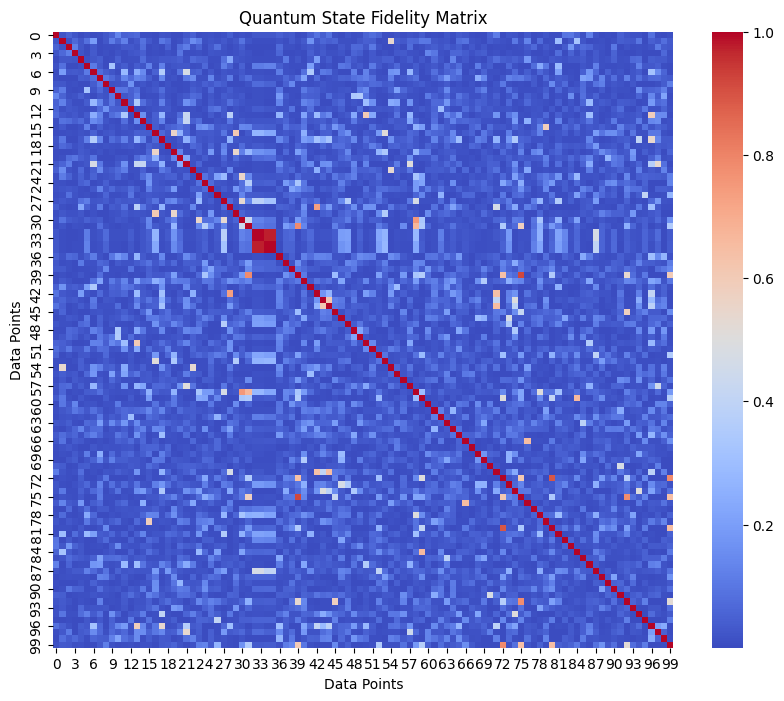

In [14]:
# Step 4: Compute Quantum State Fidelity (Distance) between data points
# Using fidelity to visualize relationships between quantum states
fidelity_matrix = np.zeros((len(X), len(X)))

for i in range(len(X)):
    sv_i = Statevector.from_instruction(quantum_circuits[i])
    for j in range(len(X)):
        sv_j = Statevector.from_instruction(quantum_circuits[j])
        fidelity_matrix[i, j] = np.abs(sv_i.inner(sv_j))**2  # Fidelity calculation
        
# Step 5: Visualize Fidelity Matrix using Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(fidelity_matrix, cmap='coolwarm', annot=False)
plt.title('Quantum State Fidelity Matrix')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.show()

## KDD 1999 Dataset

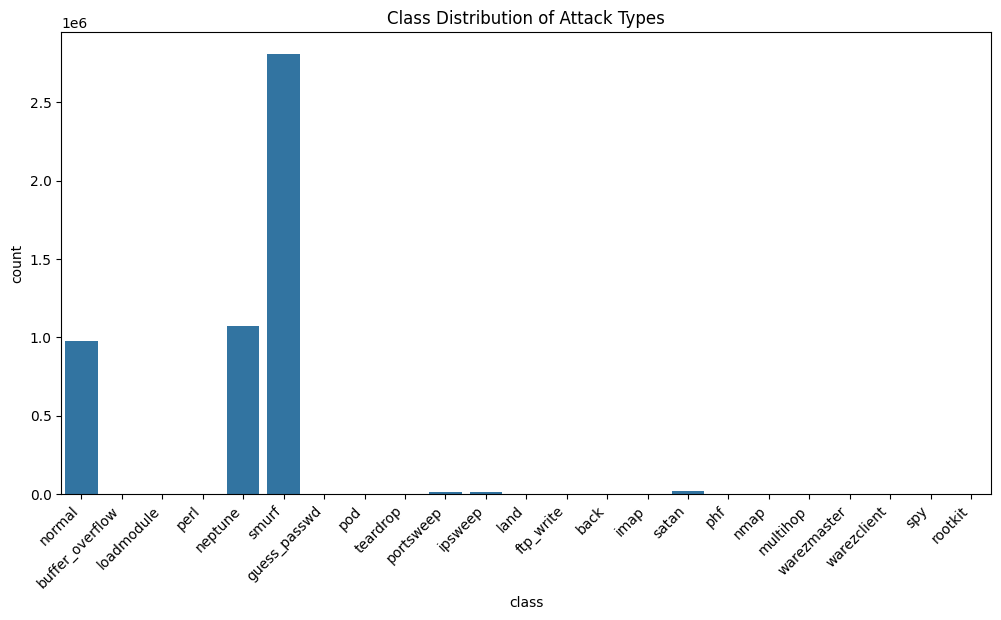

In [6]:
# 1. Class Imbalance Check
plt.figure(figsize=(12, 6))
sns.countplot(data=kdd_df, x='class')
plt.title('Class Distribution of Attack Types')
plt.xticks(rotation=45, ha='right')
plt.show()

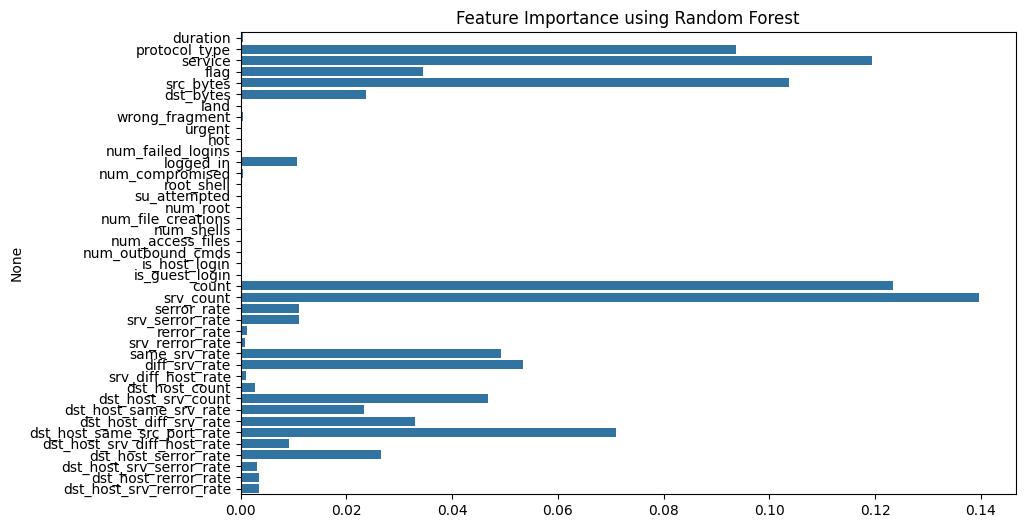

In [7]:
# 2. Feature Importance Analysis using Random Forest
# Converting categorical features into numerical for Random Forest analysis
le_protocol = LabelEncoder()
kdd_df['protocol_type'] = le_protocol.fit_transform(kdd_df['protocol_type'])

le_service = LabelEncoder()
kdd_df['service'] = le_service.fit_transform(kdd_df['service'])

le_flag = LabelEncoder()
kdd_df['flag'] = le_flag.fit_transform(kdd_df['flag'])

# Train Random Forest to find feature importance
X = kdd_df.drop(columns=['class'])
y = kdd_df['class']
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=X.columns)
plt.title('Feature Importance using Random Forest')
plt.show()

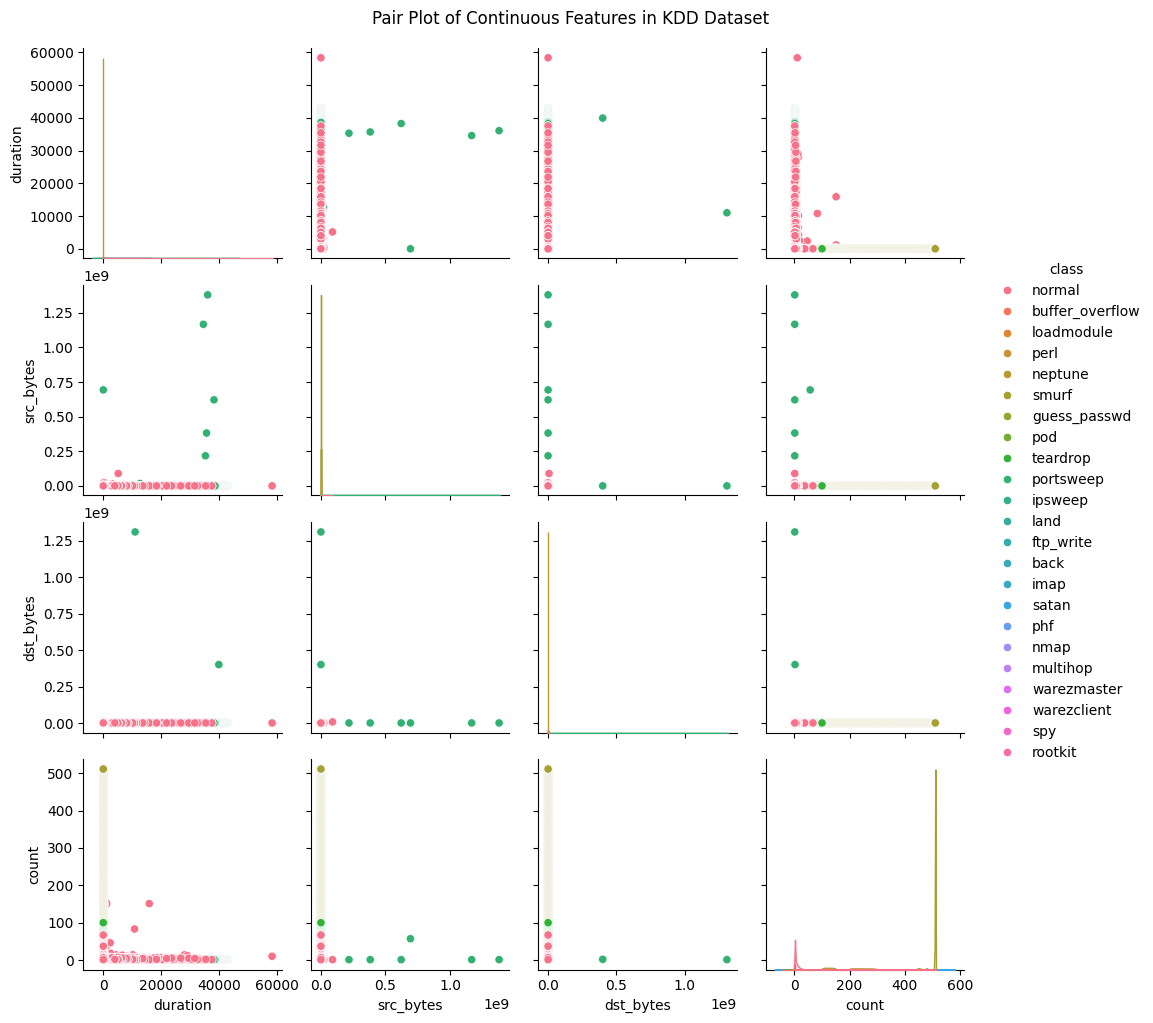

In [5]:
# 3. Pair Plot Analysis of Continuous Features
subset_features = ['duration', 'src_bytes', 'dst_bytes', 'count']
sns.pairplot(kdd_df[subset_features + ['class']], hue='class', diag_kind='kde')
plt.suptitle('Pair Plot of Continuous Features in KDD Dataset', y=1.02)
plt.show()

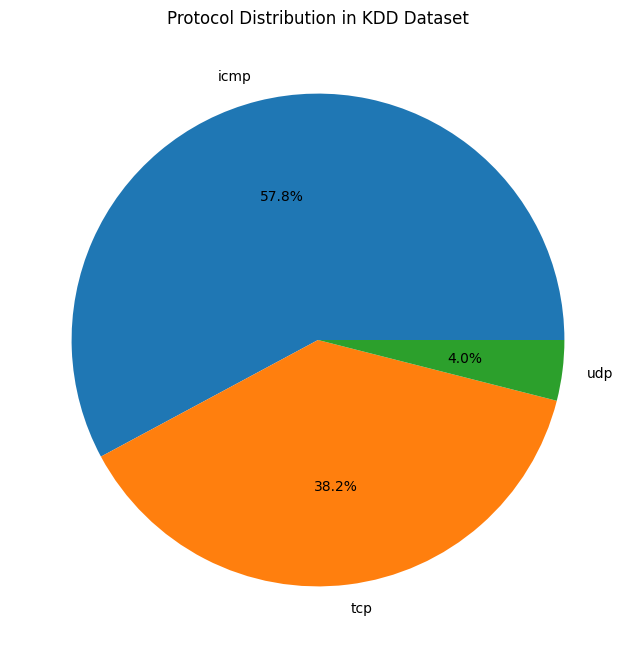

In [6]:
# 4. Protocol Analysis
protocol_counts = kdd_df['protocol_type'].value_counts()
protocol_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Protocol Distribution in KDD Dataset')
plt.ylabel('')
plt.show()

In [7]:
# 5. Heatmap of Correlations
plt.figure(figsize=(12, 8))
corr_matrix = kdd_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of KDD Cup 1999 Dataset')
plt.show()

ValueError: could not convert string to float: 'tcp'

<Figure size 1200x800 with 0 Axes>

In [24]:
# Assigning column names as per dataset description
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
           "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
           "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
           "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
           "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
           "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
           "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
           "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
           "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
           "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

kdd_df.columns = columns

# Step 1: Data Preprocessing for Quantum Embedding
# Normalize continuous features for quantum processing
continuous_features = ["duration", "src_bytes", "dst_bytes", "count", "srv_count"]
kdd_df[continuous_features] = (kdd_df[continuous_features] - kdd_df[continuous_features].mean()) / kdd_df[continuous_features].std()

# Take a subset of data for visualization to avoid computational overload
subset_data = kdd_df[continuous_features].values[:100]  # Use the first 100 samples

# Step 2: Quantum Feature Map to Embed Data into Quantum State
feature_map = ZZFeatureMap(feature_dimension=len(continuous_features), reps=2, entanglement='linear')

# Create quantum circuits for each data point
quantum_circuits = []
for datapoint in subset_data:
    circuit = feature_map.assign_parameters(datapoint)
    quantum_circuits.append(circuit)

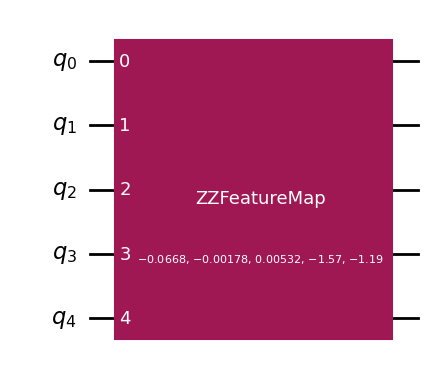

In [25]:
# Visualize one of the quantum circuits as an example
quantum_circuits[0].draw(output='mpl')

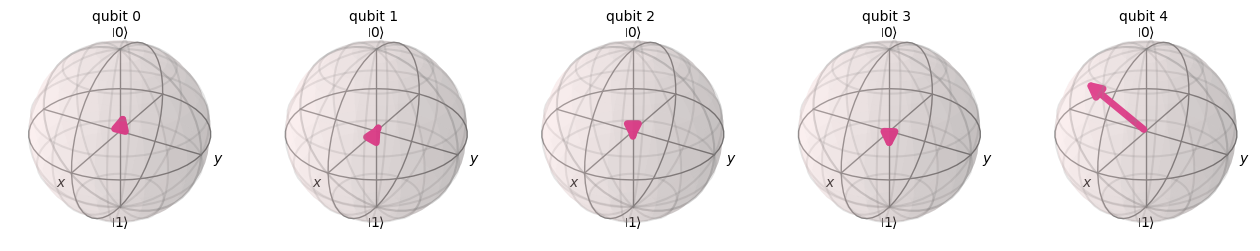

In [26]:
# Step 3: Quantum State Visualization using Bloch Sphere
backend = Aer.get_backend('statevector_simulator')

# Getting quantum state for the first data point
new_circuit = transpile(quantum_circuits[0], backend)
job = backend.run(new_circuit)
result = job.result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

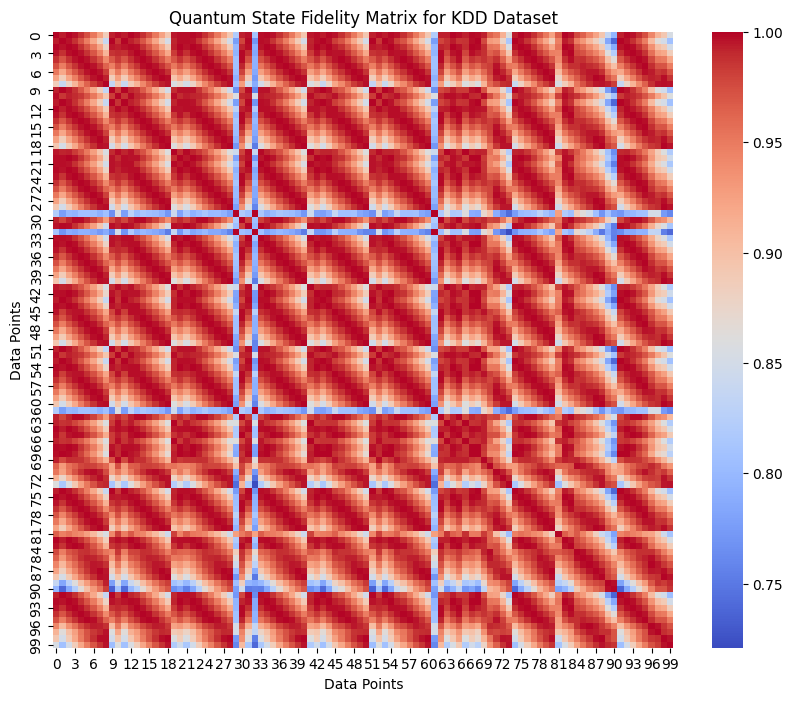

In [27]:
# Step 4: Compute Quantum State Fidelity (Distance) between data points
# Using fidelity to visualize relationships between quantum states
fidelity_matrix = np.zeros((len(subset_data), len(subset_data)))

for i in range(len(subset_data)):
    sv_i = Statevector.from_instruction(quantum_circuits[i])
    for j in range(len(subset_data)):
        sv_j = Statevector.from_instruction(quantum_circuits[j])
        fidelity_matrix[i, j] = np.abs(sv_i.inner(sv_j))**2  # Fidelity calculation

# Step 5: Visualize Fidelity Matrix using Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(fidelity_matrix, cmap='coolwarm', annot=False)
plt.title('Quantum State Fidelity Matrix for KDD Dataset')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.show()

## PIMA Diabetes Dataset

In [28]:
# Step 2: Data Preprocessing for Quantum Embedding
# Normalizing continuous features for quantum processing
continuous_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 
                       'DiabetesPedigreeFunction', 'Age']
diabetes_df[continuous_features] = (diabetes_df[continuous_features] - diabetes_df[continuous_features].mean()) / diabetes_df[continuous_features].std()

# Taking a subset of data for visualization to avoid computational overload
subset_data = diabetes_df[continuous_features].values[:100]  # Use the first 100 samples

# Step 3: Quantum Feature Encoding using ZZFeatureMap
feature_map = ZZFeatureMap(feature_dimension=len(continuous_features), reps=2, entanglement='linear')

# Create quantum circuits for each data point
quantum_circuits = []
for datapoint in subset_data:
    circuit = feature_map.assign_parameters(datapoint)
    quantum_circuits.append(circuit)


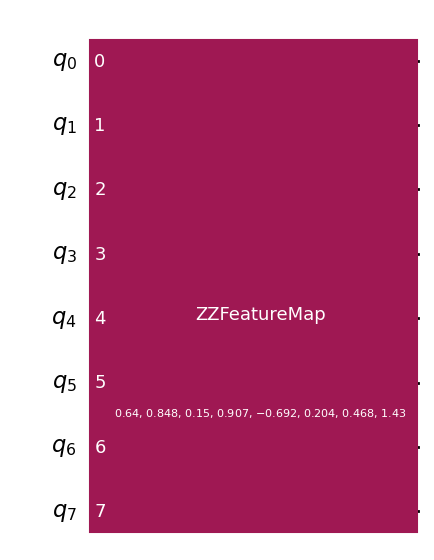

In [29]:
# Visualize one of the quantum circuits as an example
quantum_circuits[0].draw(output='mpl')

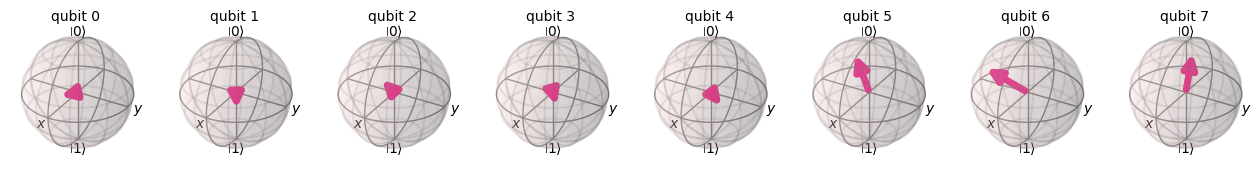

In [30]:
# Step 4: Quantum State Visualization using Bloch Sphere
backend = Aer.get_backend('statevector_simulator')

# Getting quantum state for the first data point
new_circuit = transpile(quantum_circuits[0], backend)
job = backend.run(new_circuit)
result = job.result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

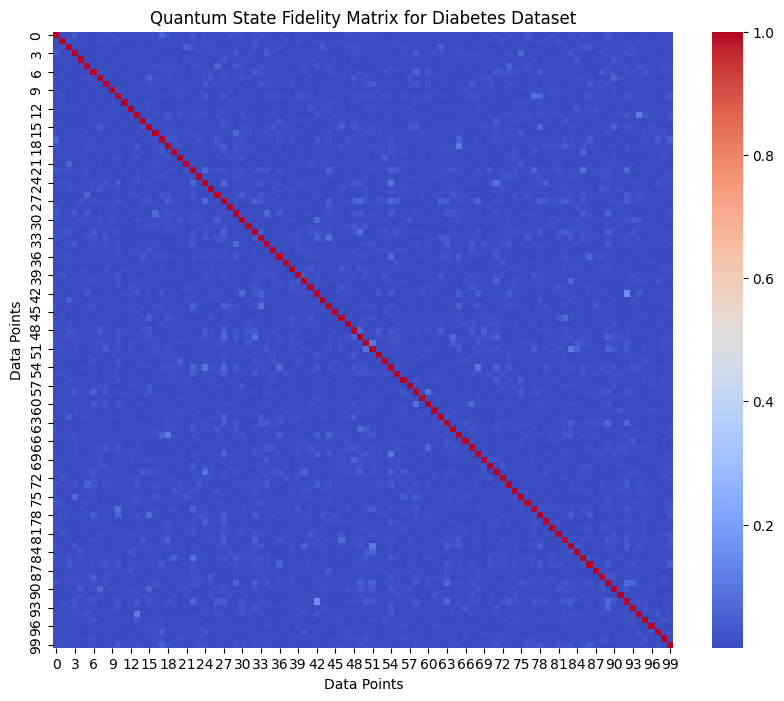

In [31]:
# Step 5: Compute Quantum State Fidelity (Distance) between data points
# Using fidelity to visualize relationships between quantum states
fidelity_matrix = np.zeros((len(subset_data), len(subset_data)))

for i in range(len(subset_data)):
    sv_i = Statevector.from_instruction(quantum_circuits[i])
    for j in range(len(subset_data)):
        sv_j = Statevector.from_instruction(quantum_circuits[j])
        fidelity_matrix[i, j] = np.abs(sv_i.inner(sv_j))**2  # Fidelity calculation

# Step 6: Visualize Fidelity Matrix using Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(fidelity_matrix, cmap='coolwarm', annot=False)
plt.title('Quantum State Fidelity Matrix for Diabetes Dataset')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.show()